# Chapter 4 Training Models

## The Normal Equation

$\hat{\theta} = (X^{T}X)^{-1} X^{T} y$

$\hat{\theta}$ = the value of $\theta$ that minimizes the cost function <br>
$y$ = the vector target values containing $y^{(1)}$ to $y^{(m)}$

Generate linear looking data

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

ValueError: x and y must be the same size

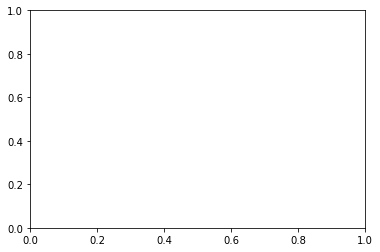

In [30]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

Compute $\hat{\theta}$ using _Normal Equation_

In [43]:
X_b = np.c_[np.ones((100,1)), X] # add x0 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [44]:
>>> theta_best

array([[3.98524982],
       [3.03387409]])

Hoped for $\theta_{0}$ = 4 and $\theta_{1}$ = 3 but the noise made it impossible to recover the exact parameters of the normal function

Make some predictions using theta hat

In [45]:
>>> X_new = np.array([[0], [2]])
>>> X_new_b = np.c_[np.ones((2, 1)), X_new]
>>> y_predict = X_new_b.dot(theta_best)
>>> y_predict

array([[ 3.98524982],
       [10.05299801]])

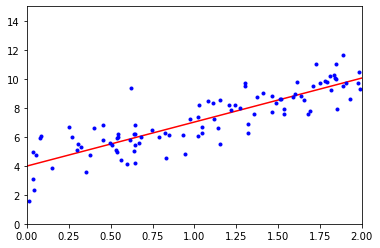

In [46]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b. ')
plt.axis([0, 2, 0, 15])
plt.show()

Linear Regression using Scikit-Learn

In [47]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [48]:
>>> lin_reg.intercept_, lin_reg.coef_

(array([3.98524982]), array([[3.03387409]]))

In [49]:
>>> lin_reg.predict(X_new)

array([[ 3.98524982],
       [10.05299801]])

`LinearRegression` is based on the `scipy.linalg.lstsq()` function (stands for "least squares")

In [50]:
>>> theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
>>> theta_best_svd

array([[3.98524982],
       [3.03387409]])

Function computes $\hat{\theta}$ = $ X^{+}y $ where $X^{+}$ is the _pseudoinverse_ of X (Moore-Penrose inverse). Use `np.linalg.pinv()` to compute pseudoinverse directly

In [51]:
>>> np.linalg.pinv(X_b).dot(y)

array([[3.98524982],
       [3.03387409]])

Pseudoinverse is comnputed using a standard matrix factorization technique called _Singular Value Decomposition_ (SVD). This approach is more efficient than using the Normal Equation.

### Computational Complexity

Normal Equation computes the inverse of $X^{t}X$. _Computational complexity_ of this is about $O(n{3})$. <br>
The SVD approach is about $O(n^{2})$.<br>
Both these methods are very slow when the number of features grows large but are linear with regard to the number of instances in the training set, so they handle large training sets efficiently, provided they can fit in memory.

## Gradient Descent

### Batch Gradient Descent

In [52]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

for _ in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [53]:
>>> theta

array([[3.98524982],
       [3.03387409]])

Exactly what the Normal Equation found

### Stochastic Gradient Descent

In [54]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index+1]
        yi = y[random_index : random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [55]:
>>> theta

array([[3.9747053 ],
       [3.04067868]])

We iterate by rounds of m iterations; each round is called an _epoch_. Batch Gradient Descent code iterated 1000 times through the whole training set, this code goes through the training set only 50 times and reaches a pretty good solution

To perform Linear Regression using Stochastic GD with Scikit-Learn, use `SGDRegressor`, which defaults to optimizing the squared error cost function. 

In [56]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [57]:
>>> sgd_reg.intercept_, sgd_reg.coef_

(array([3.95596811]), array([3.03093419]))

## Polynomial Regression

For data that is more complex than a straight line

Text(0, 0.5, 'y')

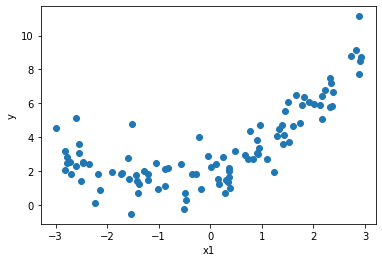

In [58]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y)
plt.xlabel('x1')
plt.ylabel('y')

Straight line would never fit this data properly. Use Scikit-Learn's `PolynomialFeatures`

In [59]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [60]:
>>> X[0]

array([-0.04779338])

In [61]:
X_poly[0]

array([-0.04779338,  0.00228421])

X_poly contains the original feature of X plus the square of this feature. Now you can fit a `LinearRegression` model to this extended training data

In [62]:
>>> lin_reg = LinearRegression()
>>> lin_reg.fit(X_poly, y)
>>> lin_reg.intercept_, lin_reg.coef_

(array([1.89145961]), array([[1.00032418, 0.49963753]]))

Model estimates $\hat{y} = 0.502x_{1}^{2} + 1.04x_{1} + 2.04$

Actual is $y = 0.5x_{1}^{2} + 1.0x_{1} + 2.0$ + Gaussian noise

## Learning Curves

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.legend()

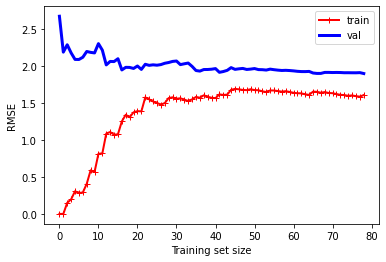

In [64]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

**Training data**: with just one or two instances, the model can predict perfectly (hence why the error starts at 0). As more instances are added, the model is less likely to predict properly until it reaches a point where adding new instances doesn't make the average error much better or worse.

**Validation data**: with just a couple of instances, it's impossible for the model to predict accuractely (hence the error starts very high). As more instances are added, the model learns and the error decreases until it reaches a plateau similar in height to the training data. 

These learning curves are typical of a model that is underfitting. Both curves plateau; they are close with relatively high error. 

10th degree polynomial model

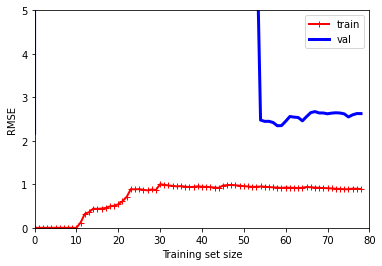

In [65]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plt.xlim(0, 80)
plt.ylim(0, 5)
plot_learning_curves(polynomial_regression, X, y)

1. Much lower error
2. Gap between the curves (overfitting). However, using a larger training set would bring the curves closer together

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model (constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data.

### Ridge Regression

_Ridge Regression_ (also called _Tikhonov regularization_): regularized version of Linear Regression where  $\alpha\sum\limits_{i=1}^{n}\theta_{i}^{2}$ is added to cost function

Note: regularization term should only be added to the cost function during training

$\alpha$ controls how much you want to regularize the model. If $\alpha=0$ then Ridge Regression is just Linear Regression

How to use Ridge Regression on Scikit-Learn

In [66]:
>>> from sklearn.linear_model import Ridge
>>> ridge_reg = Ridge(alpha=1, solver="cholesky")
>>> ridge_reg.fit(X, y)
>>> ridge_reg.predict([[1.5]])

array([[4.77739218]])

Also using Stochastic Gradient Descent

In [67]:
>>> sgd_reg = SGDRegressor(penalty='l2')
>>> sgd_reg.fit(X, y.ravel())
>>> sgd_reg.predict([[1.5]])

array([4.74365834])

`penalty` hyperparameter sets the type of regularization term to use. "l2" basically makes it Ridge Regression

### Lasso Regression

_Least Abolute Shrinkage and Selection Operator Regression_: also adds a regularization term to the cost function

$\alpha\sum\limits_{i=1}^{n}|\theta_{i}|$

Lasso tends to eliminate the weights of the least important features (i.e sets them to 0). I.e Lasso regression automatically performs feature selection and ouputs a _sparse model_ (i.e with few nonzero feature weights). 

In [68]:
>>> from sklearn.linear_model import Lasso
>>> lasso_reg = Lasso(alpha=0.1)
>>> lasso_reg.fit(X, y)
>>> lasso_reg.predict([[1.5]])

array([4.73230652])

Note: you could instead use SGDRegressor(penalty="l1")

### Elastic Net

A middle ground between Ridge Regression and Lasso Regression. Regularization term is a mix of both of the previous regressions' terms with a mix ratio _r_. When _r_ = 0, Elastic Net is equivalent to Ridge Regression and when _r_ = 1, it is equivalent to Lasso Regression.

$r\alpha\sum\limits_{i=1}^{n}|\theta_{i}| + \frac{1-r}{2}\alpha\sum\limits_{i=1}^{n}\theta_{i}^{2}$

When should I use plain linear regression? It is almost always preferable to have some regularization. Ridge Regression is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features' weights down to zero. In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated. 

In [69]:
>>> from sklearn.linear_model import ElasticNet
>>> elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
>>> elastic_net.fit(X, y)
>>> elastic_net.predict([[1.5]])

array([4.73502704])

### Early Stopping

Another way to regularize iterative learning algorithms by stopping training as soon as the validation error reaches a minimum

In [71]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate='constant', eta0=0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None 
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it is left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vecto

/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vecto

## Logistic Regression

_Logit Regression_: commonly used to estimate the probability that an instance belongs to a particular class

### Estimating Probabilities

Instead of outputting the result directly like the Linear Regression, it outputs the _logistic_ of the result

Logistic - noted $\sigma$ - is a _sigmoid function_ (i.e S-shaped) that outputs a number between 0 and 1

$\sigma(t) = \frac{1}{1 + e^{-t}}$

### Training and Cost Function

$-log(\hat{p})$ if y = 1 <br>
$-log(1-\hat{p})$ if y = 0

Makes sense because -log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance

There is no known closed-form equation to compute the value of $\Large \theta$ that minimizes the cost function (no equivalent of the Normal Equation). But the cost function is convex, so Gradient Descent (or any other optimization function) is guranteed to find the global minimum. 

### Decision Boundaries

Build a classifier to detect the _Iris virginica_ (from Iris dataset) based only on the petal width feature

In [3]:
>>> from sklearn import datasets
>>> iris = datasets.load_iris()
>>> list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [73]:
>>> X = iris["data"][:, 3:] # petal width
>>> y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0

/var/folders/f8/hxc0ryjs0gb7fdk4nxbgtg2c0000gn/T/ipykernel_1570/604732857.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0


In [74]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

/Users/arturo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/matplotlib/patches.py:1444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


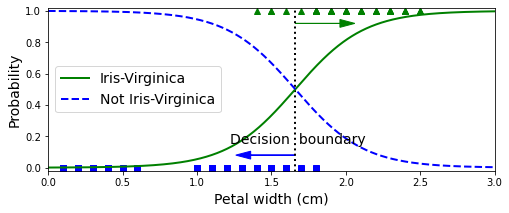

In [79]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

### Softmax Regression

Logistic Regression that combines multiple binary classifiers (also knows as _Multinomial Logistic Regression_)

`LogisticRegression` uses one-versus-the-rest by default when you train it with more than two classes, but set the `multi_class` hyperparamter to `"multinomial"` to switch it to Softmax Regression. Also specify a solver that supports Softmax Regression such as the `"lbfgs"` solver

In [81]:
X = iris["data"][:, (2,3)] # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [82]:
>>> softmax_reg.predict([[5, 2]])

array([2])

In [83]:
>>> softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## Exercises

1. Which Linear Regression training algorithm can you use if you have a training set with millions of features?

Mini-batch gradient descent - gets a performance boost from hardware optimizations of matrix operations, especially when using GPUs.

*Stochasitic and Batch Gradient Descent can also be used if the training set fits in memory. You cannot use the Normal Equation or the SVD approach because the computational complexity grows more than quadratically with the number of features*

2. Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?

? Use regularized regression

*The cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. Scale the data bnefore training the model to fix this. Note that the Normal Equation or SVD approach work fine without scaling. Moreover, regularized models may converge to suboptimal solutions if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values* 

3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression Model?

Yes - if the learning rate is too small

*It cannot get stuck when training a Logistic Regression model because the cost function is convex*

4. Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough?

They should if you have the hyperparamters are set properly so they don't get stuck in local minimumns

*If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge*

5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

The learning rate is too high. Lower it, or use grid search to find the optimal learning rate

*If the training error also goes up, then clearly the learning rate is too high and should be lowered. However, if the training error is not going up, then the model is overfitting the training set and you should stop training*

5. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

No. Similar to Stochastic Gradient Descent, the validation error will bounce around.

*A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model*

7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

The fastest solution is Mini-batch. The solution that always converges is Batch. The other can converge if the hyperparameters are set properly using grid search.

*SGD has the fastest training iteration since it consideres only one training instance at a time (or Mini-batch GD with a very small mini-batch size). SGD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate*

8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

If the training error is lower than the validation error, the model is overfitting. This means that the model is too complex, or the polynomial degree being used is too high. To fix this, lower the polynomial degree (simplify the model), clean the data of noisiness, and feed it more training data until the validation error reaches the training error. 

*Also try regularizing the model (will reduce the degrees of freedom)*

9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter $\alpha$ or reduce it?

The model is suffering from high bias. It is generalizing the data efficiently but not accurately. $\alpha$ should be reduced to increase variance and lower bias. 

*Underfitting*

10. Why would you want to use: <br>
    a. Ridge Regression instead of plain Linear Regression (ie without any regularization)? <br>
    b. Lasso instead of Ridge Regression? <br>
    c. Elastic Net instead of Lasso?

a. A bit of regularization is always preferred because of the tendencies to overfit data <br>
b. If there are few useful features, it tends to reduce the useless features' weights to zero<br>
c. Lasso behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated

*All good here*

11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

*They are not exclusive classes (ie all four combinations are possible), train two Logistic Regression classifiers*

12. Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)

Load the data

In [4]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

add bias term for every instance $x_{0} = 1$

In [5]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

set the random seed so the output of this exercise solution is reproducible

In [6]:
np.random.seed(2042)

split dataset into training set, validation set, and test set

In [7]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

Targets are class indices (0, 1, or 2) but we need target class probabilites for softmax. Each instance will have target class probabilites equal to 0.0 for all classes except for the target calss which will have a probability of 1.0 (the vector of the class probabilites for ay given instance is a one-hot vector).

In [11]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [12]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [13]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

create the target class probabilites matrix for the training set and the test set

In [14]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

implement softmax

<span style="font-size:large;">$\sigma(s(x))_{k} = \frac{exp(s_{k}(x))}{\sum^{K}_{j=1}exp(s_{j}(x))}$</span>

In [15]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

define the number of inputs and outputs

In [16]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train)) # == 3 (3 iris classes)

Training. Translate maths into Python code
<br>
cost function: <br>
$J(\mathbf{\Theta}) =
\dfrac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$
<br>
gradients: <br>


In [23]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis = 1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 3.2078708887337366
500 0.9102655715933008
1000 0.7245981143541181
1500 0.6195736452392622
2000 0.5544764557510471
2500 0.510121522324934
3000 0.4775255492382668
3500 0.4521715148580381
4000 0.43159764596466277
4500 0.4143616863014782
5000 0.39956523349383644


Model is trained. Lets look at the model parameters

In [22]:
Theta

array([[ 4.29312369,  0.03073838, -1.97193784],
       [-1.0965798 ,  0.32806673,  0.07745712],
       [-0.11010737,  0.35188545,  2.42549367]])

Lets make predictions for the validation set and check the accuracy score

In [24]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Add some regularization

In [25]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 1.917176734451636
500 0.5274853292670175
1000 0.5018023845792812
1500 0.4940174227384021
2000 0.49102560158394926
2500 0.4897840819604775
3000 0.48924876073664003
3500 0.489012778167513
4000 0.4889073274143668
4500 0.4888597962589991
5000 0.4888382509943693


Because of the additional l2 penalty, the loss seems greater than earlier

In [26]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Perfect accuracy. <br>
Add early stopping. measure the loss on the validation set at every iteration and stop when the error starts growing

In [27]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 3.0379844070591444
500 0.5632473005038078
1000 0.540980163037904
1500 0.5348208732520805
2000 0.5329877623278658
2500 0.5325626967289966
2664 0.5325456266294482
2665 0.5325456266681172 early stopping!


In [28]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Faster<br>
Plot the model's predictions on the whole dataset

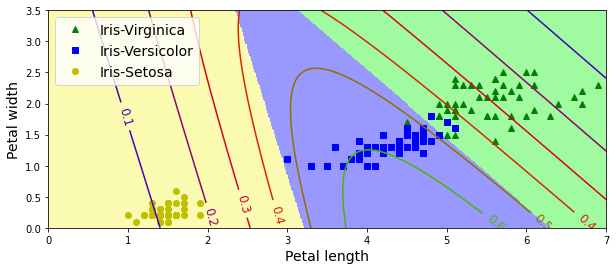

In [31]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

Measure final model's accuracy on test set

In [32]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set, and test set, you can get quite different results. Results will vary if you change the random seed